# Predict Reviews with BERT in the Notebook (AdHoc)

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Retrieve the Training Job Name

In [2]:
%store -r training_job_name

In [3]:
try:
    training_job_name
except NameError:
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('[ERROR] Please wait for the previous notebook to finish.')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [4]:
print('Previous training_job_name: {}'.format(training_job_name))

Previous training_job_name: tensorflow-training-2020-09-26-18-44-25-975


# Download the Trained Model

In [5]:
models_dir = './models'

In [6]:
# Download the model and output artifacts from AWS S3
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz $models_dir/model.tar.gz

download: s3://sagemaker-us-west-2-085964654406/tensorflow-training-2020-09-26-18-44-25-975/output/model.tar.gz to models/model.tar.gz


In [7]:
import tarfile
import pickle as pkl

#!ls -al ./models

tar = tarfile.open('{}/model.tar.gz'.format(models_dir))
tar.extractall(path=models_dir)
tar.close()

In [8]:
!ls -al $models_dir

total 825192
drwxrwxr-x  7 ec2-user ec2-user      4096 Sep 26 19:21 .
drwxrwxr-x 11 ec2-user ec2-user      4096 Sep 26 19:21 ..
drwxr-xr-x  2 ec2-user ec2-user      4096 Sep 26 19:17 code
drwxr-xr-x  2 ec2-user ec2-user      4096 Sep 26 19:17 metrics
-rw-rw-r--  1 ec2-user ec2-user 844962197 Sep 26 19:18 model.tar.gz
drwxr-xr-x  2 ec2-user ec2-user      4096 Sep 26 18:47 tensorboard
drwxr-xr-x  3 ec2-user ec2-user      4096 Sep 26 18:47 tensorflow
drwxr-xr-x  4 ec2-user ec2-user      4096 Sep 26 18:47 transformers


# Load the Model

In [9]:
transformer_model_dir = '{}/transformers/fine-tuned/'.format(models_dir)

!ls -al $transformer_model_dir

total 261692
drwxr-xr-x 2 ec2-user ec2-user      4096 Sep 26 19:16 .
drwxr-xr-x 4 ec2-user ec2-user      4096 Sep 26 18:47 ..
-rw-r--r-- 1 ec2-user ec2-user      1358 Sep 26 19:16 config.json
-rw-r--r-- 1 ec2-user ec2-user 267959068 Sep 26 19:16 tf_model.h5


In [10]:
cat $transformer_model_dir/config.json

{
  "_num_labels": 5,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true

In [11]:
import os
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(transformer_model_dir,
                                                                     id2label={
                                                                       0: 1,
                                                                       1: 2,
                                                                       2: 3,
                                                                       3: 4,
                                                                       4: 5
                                                                     },
                                                                     label2id={
                                                                       1: 0,
                                                                       2: 1,
                                                                       3: 2,
                                                                       4: 3,
                                                                       5: 4
                                                                     })

In [12]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

inference_device = -1 # CPU: -1, GPU: 0
print('inference_device {}'.format(inference_device))

inference_device -1


In [13]:
from transformers import TextClassificationPipeline

inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=inference_device) # -1 is CPU, >= 0 is GPU

# THESE PREDICTIONS WILL NOT BE ACCURATE  

Here are the reasons:
* we are not using the full dataset
* we are only training for 50 steps
* we are using a small training cluster

_This same BERT model achieves close to 97% accuracy when training longer, using a larger training cluster, and using more data._

In [14]:
review = """I loved it!"""
print(review, inference_pipeline(review))

I loved it! [{'label': 5, 'score': 0.9317545}]


In [15]:
review = """Not that good."""
print(review, inference_pipeline(review))

Not that good. [{'label': 2, 'score': 0.89972657}]


# Test Model

In [16]:
import csv

df_test_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')[['review_body', 'star_rating']]

df_test_reviews = df_test_reviews.sample(n=100)

df_test_reviews.shape

(100, 2)

# Actual Star Rating

In [17]:
df_test_reviews.head()

,review_body,star_rating
63043,After 20 years of doing business with Symantec...,1
27547,Found a coupon that would have saved me $10 AF...,4
79429,I installed it and it works for what I need. ...,4
72633,Norton has an easy to use interface and offers...,5
93081,Since long time ago I used Microsoft office fo...,5


In [18]:
y_actual = df_test_reviews['star_rating']

y_actual

63043     1
27547     4
79429     4
72633     5
93081     5
         ..
77938     3
32707     5
101208    1
6851      5
71366     5
Name: star_rating, Length: 100, dtype: int64

# Predicted Star Rating

In [19]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body[0:512])
    return prediction_map[0]['label']
    
y_test = df_test_reviews['review_body'].map(predict)

y_test

63043     1
27547     4
79429     3
72633     4
93081     5
         ..
77938     3
32707     4
101208    1
6851      3
71366     4
Name: review_body, Length: 100, dtype: int64

# Classification Report:  Compare Actual to Predicted

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_actual))

              precision    recall  f1-score   support

           1       0.65      0.58      0.61        19
           2       0.60      0.23      0.33        13
           3       0.55      0.23      0.32        26
           4       0.38      0.34      0.36        29
           5       0.29      0.92      0.44        13

    accuracy                           0.42       100
   macro avg       0.49      0.46      0.42       100
weighted avg       0.49      0.42      0.41       100



# Accuracy

In [21]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_actual))

Accuracy:  0.42


# Confusion Matrix

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[11  2  3  3  0]
 [ 5  3  2  2  1]
 [ 1  0  6 10  9]
 [ 0  0  0 10 19]
 [ 0  0  0  1 12]]


<Figure size 432x288 with 0 Axes>

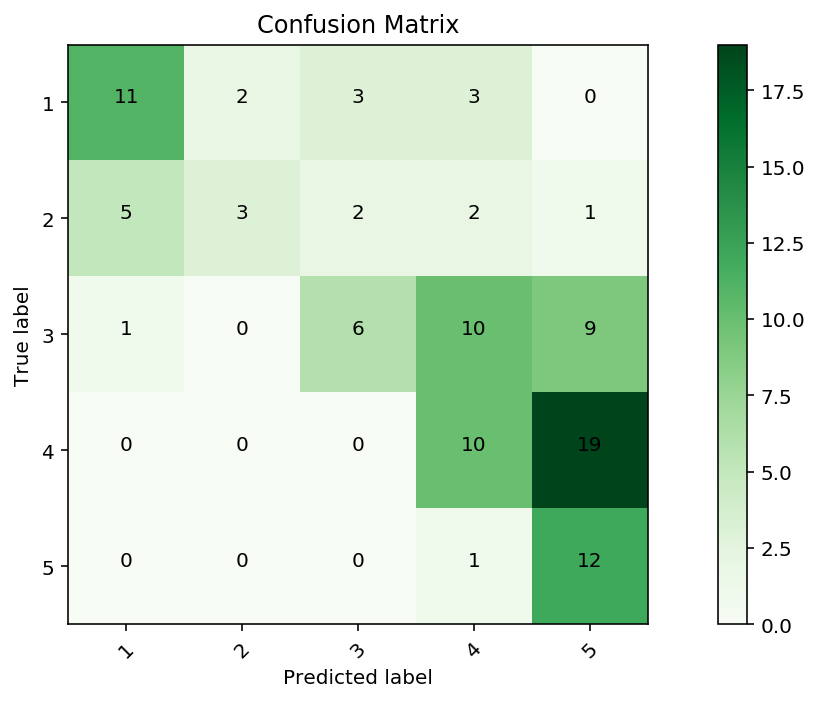

In [23]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_test, y_pred=y_actual)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();